# Мошеннические вакансии

Источник данных: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction <br>

## Данные

Список признаков (`Переменная`: Значение):

- `job_id`: Уникальный ID вакансии в таблице<br>
- `title`: Заголовок<br>
- `location`: Географическое положение объявления о работе<br>
- `department`: Корпоративный отдел (например: продажи/sales)<br>
- `salary_range`: Диапазона предлагаемого размера зарплаты (например: $50,000-60,000)<br>
- `company_profile`: Краткое описание компании<br>
- `description`: Описание предлагаемой работы<br>
- `requirements`: Требования к работнику<br>
- `benefits`: Преимущества устройства на работу<br>
- `telecommuting`: Является ли работа удалённой (или возможен ли такой вариант трудоустройства)<br>
- `has_company_logo`: Указан ли логотип компании<br>
- `has_questions`: Указано ли в вакансии, что предполагаются дополнительные вопросы к соискателю (обсуждение, собеседование)<br>
- `employment_type`: Тип трудоустройства: Full-type (постоянная работа), Part-time (временная), Contract (контракт), и так далее<br>
- `required_experience`: Требуемый опыт работы: Executive (должностное лицо), Entry level (отсутствие опыта), и так далее<br>
- `required_education`: Требуемый уровень образования: Doctorate (докторская степень), Master’s Degree (степень магистра), Bachelor (степень бакалавра), и так далее<br>
- `industry`: Индустрия: Automotive, IT, Health care, Real estate, и так далее<br>
- `function`: Функция в компании: Consulting, Engineering, Research, Sales и так далее<br>
- `fraudulent`: Целевая переменная - мошенническая ли вакансия<br>

__fake_job_postings.csv__ - датасет

In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
from tqdm import tqdm
from collections import Counter
from itertools import tee

from IPython.display import display

import numpy as np
import scipy as sp
import mystatutils as stats
from scipy.sparse import hstack as sparse_hstack
import pandas as pd

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

import eli5

Using TensorFlow backend.


## Первый взгляд

Датасет:

In [2]:
data = pd.read_csv('fake_job_postings.csv')
data.head(10)

job_id                                      title               location  \
0       1                           Marketing Intern       US, NY, New York   
1       2  Customer Service - Cloud Video Production         NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)          US, IA, Wever   
3       4          Account Executive - Washington DC     US, DC, Washington   
4       5                        Bill Review Manager     US, FL, Fort Worth   
5       6                           Accounting Clerk               US, MD,    
6       7                      Head of Content (m/f)         DE, BE, Berlin   
7       8           Lead Guest Service Specialist     US, CA, San Francisco   
8       9                                 HP BSM SME      US, FL, Pensacola   
9      10    Customer Service Associate - Part Time         US, AZ, Phoenix   

   department salary_range                                    company_profile  \
0   Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1     Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2         NaN          NaN  Valor Services provides Workforce Solutions th...   
3       Sales          NaN  Our passion for improving quality of life thro...   
4         NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   
5         NaN          NaN                                                NaN   
6  ANDROIDPIT  20000-28000  Founded in 2009, the Fonpit AG rose with its i...   
7         NaN          NaN  Airenvy’s mission is to provide lucrative yet ...   
8         NaN          NaN  Solutions3 is a woman-owned small business who...   
9         NaN          NaN  Novitex Enterprise Solutions, formerly Pitney ...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   
5  Job OverviewApex is an environmental consultin...   
6  Your Responsibilities: Manage the English-spea...   
7  Who is Airenvy?Hey there! We are seasoned entr...   
8  Implementation/Configuration/Testing/Training ...   
9  The Customer Service Associate will be based i...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   
5                                                NaN   
6  Your Know-How:                                ...   
7  Experience with CRM software, live chat, and p...   
8  MUST BE A US CITIZEN.An active TS/SCI clearanc...   
9  Minimum Requirements:Minimum of 6 months custo...   

                                            benefits  telecommuting  \
0                                                NaN              0   
1  What you will get from usThrough being part of...              0   
2                                                NaN              0   
3  Our culture is anything but corporate—we have ...              0   
4                              Full Benefits Offered              0   
5                                                NaN              0   
6  Your Benefits: Being part of a fast-growing co...              0   
7  Competitive Pay. You'll be able to eat steak e...              0   
8                                                NaN              0   
9                                                NaN              0   

   has_company_logo  has_questions employment_type required_experience  \
0                 1              0           Other          Internship   
1                 1              0       Full-time      Not Applicable   
2  

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

В таблице довольно много пропущенных значений. Также есть признаки, требующие дополнительной обработки. Сохраним имена столбцов для каждого типа признака и обработаем те из них, что того требуют (текстовые признаки, а также составные: `location` и `salary_range`):

In [4]:
bin_features = ['telecommuting', 'has_company_logo', 'has_questions']
cat_features = ['department', 'employment_type', 'required_experience', 
                'required_education', 'industry', 'function']

text_features = ['title', 'company_profile', 'description', 'requirements', 'benefits']
complex_features = ['location', 'salary_range']

И удалим столбец `job_id`, он бесполезен.

In [5]:
data.drop('job_id', axis=1, inplace=True)

## Подготовка признаков

### Текстовые признаки

Признаки, описывающие текстовые составляющие вакансии:

In [6]:
data[text_features].head()

title  \
0                           Marketing Intern   
1  Customer Service - Cloud Video Production   
2    Commissioning Machinery Assistant (CMA)   
3          Account Executive - Washington DC   
4                        Bill Review Manager   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  
0                                                NaN  
1  What you will get from usThrough being part of...  
2                                                NaN  
3  Our culture is anything but corporate—we have ...  
4                              Full Benefits Offered

Добавим индикаторы наличия значений (так как в столбце `title` нет пропущенных значений, он обработан не будет):

In [7]:
for feature_name in text_features[1:]:
    unspec_feature_name = f'{feature_name}_specified'
    data[unspec_feature_name] = (~data[feature_name].isna()).astype('int')
    # дополняем список имён бинарных признаков
    bin_features += [unspec_feature_name]

In [8]:
data.head()[text_features + bin_features[-4:]]

title  \
0                           Marketing Intern   
1  Customer Service - Cloud Video Production   
2    Commissioning Machinery Assistant (CMA)   
3          Account Executive - Washington DC   
4                        Bill Review Manager   

                                     company_profile  \
0  We're Food52, and we've created a groundbreaki...   
1  90 Seconds, the worlds Cloud Video Production ...   
2  Valor Services provides Workforce Solutions th...   
3  Our passion for improving quality of life thro...   
4  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Food52, a fast-growing, James Beard Award-winn...   
1  Organised - Focused - Vibrant - Awesome!Do you...   
2  Our client, located in Houston, is actively se...   
3  THE COMPANY: ESRI – Environmental Systems Rese...   
4  JOB TITLE: Itemization Review ManagerLOCATION:...   

                                        requirements  \
0  Experience with content management systems a m...   
1  What we expect from you:Your key responsibilit...   
2  Implement pre-commissioning and commissioning ...   
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...   
4  QUALIFICATIONS:RN license in the State of Texa...   

                                            benefits  \
0                                                NaN   
1  What you will get from usThrough being part of...   
2                                                NaN   
3  Our culture is anything but corporate—we have ...   
4                              Full Benefits Offered   

   company_profile_specified  description_specified  requirements_specified  \
0                          1                      1                       1   
1                          1                      1                       1   
2                          1                      1                       1   
3                          1                      1                       1   
4                          1                      1                       1   

   benefits_specified  
0                   0  
1                   1  
2                   0  
3                   1  
4                   1

И заполним пропущенные значения пустой строкой:

In [9]:
for feature_name in text_features[1:]:
    data[feature_name].fillna('', inplace=True)

Теперь необходимо очистить тексты от знаков препинания и стоп-слов, а также применить стемминг (или лемматизацию, или приведение слов к нормальной форме, я использовал стемминг):

In [10]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [11]:
nltk_supported_languages = ['hungarian', 'swedish', 'kazakh', 'norwegian',
                            'finnish', 'arabic', 'indonesian', 'portuguese',
                            'turkish', 'azerbaijani', 'slovene', 'spanish',
                            'danish', 'nepali', 'romanian', 'greek', 'dutch',
                            'tajik', 'german', 'english', 'russian',
                            'french', 'italian']

In [12]:
# список стоп-слов
stop_words = set(stopwords.words(nltk_supported_languages))

In [13]:
# стеммер
porter = PorterStemmer()

In [14]:
def preprocess_texts(texts):
    '''Возвращает список подготовленных текстов.'''
    preprocessed_texts = []
    for text in tqdm(texts):
        # удаление знаков препинания
        text = ''.join([sym.lower() for sym in text if sym.isalpha() or sym == ' '])
        
        # токенизация
        tokenized_text = word_tokenize(text)
        
        # удаление стоп-слов
        tokenized_text_wout_sw = [word for word in tokenized_text if word not in stop_words]
        
        # стемминг
        tokenized_text_wout_sw_stem = [porter.stem(word) for word in tokenized_text_wout_sw]
        
        # сохранение результата
        preprocessed_texts += [' '.join(tokenized_text_wout_sw_stem)]
    
    return preprocessed_texts

In [15]:
%%time
for feature_name in text_features:
    data[feature_name] = preprocess_texts(data[feature_name])

data[text_features].head()

100%|██████████| 17880/17880 [00:16<00:00, 1115.84it/s]

CPU times: user 3min 13s, sys: 1.58 s, total: 3min 14s
Wall time: 3min 15s


title  \
0                      market intern   
1  custom servic cloud video product   
2       commiss machineri assist cma   
3       account execut washington dc   
4                  bill review manag   

                                     company_profile  \
0  food weve creat groundbreak awardwin cook site...   
1  second world cloud video product servic second...   
2  valor servic provid workforc solut meet need c...   
3  passion improv qualiti life geographi heart ev...   
4  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  
0                                                     
1  get usthrough part second team gainexperi work...  
2                                                     
3  cultur anyth corporatew collabor creativ envir...  
4                                 full benefit offer

Готово! Теперь обработаем составные признаки.

### Составные признаки

#### `location`

Структурой записей признака `location` является `Страна, Область (штат), Город`:

In [16]:
location = data['location'].copy()
location.head(15)

0          US, NY, New York
1            NZ, , Auckland
2             US, IA, Wever
3        US, DC, Washington
4        US, FL, Fort Worth
5                  US, MD, 
6            DE, BE, Berlin
7     US, CA, San Francisco
8         US, FL, Pensacola
9           US, AZ, Phoenix
10      US, NJ, Jersey City
11          GB, LND, London
12         US, CT, Stamford
13          US, FL, Orlando
14          AU, NSW, Sydney
Name: location, dtype: object

Разделим и извлечём эти элементы. Превратим один категориальный признак в три.

In [17]:
location_splitted = list(location.str.split(', ').values)
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', '', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', ''],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

Заполним пропущенные значения (будем использования строчку `'Unspecified'` для индикации пропущенных значений во всех категориальных признаках):

In [18]:
for loc_ind, loc in enumerate(location_splitted):
    if loc is np.nan:
        location_splitted[loc_ind] = ['Unpecified'] * 3
    else:
        for el_ind, el in enumerate(loc):
            if el == '':
                loc[el_ind] = 'Unpecified'

In [19]:
location_splitted[:15]

[['US', 'NY', 'New York'],
 ['NZ', 'Unpecified', 'Auckland'],
 ['US', 'IA', 'Wever'],
 ['US', 'DC', 'Washington'],
 ['US', 'FL', 'Fort Worth'],
 ['US', 'MD', 'Unpecified'],
 ['DE', 'BE', 'Berlin'],
 ['US', 'CA', 'San Francisco'],
 ['US', 'FL', 'Pensacola'],
 ['US', 'AZ', 'Phoenix'],
 ['US', 'NJ', 'Jersey City'],
 ['GB', 'LND', 'London'],
 ['US', 'CT', 'Stamford'],
 ['US', 'FL', 'Orlando'],
 ['AU', 'NSW', 'Sydney']]

Но есть некоторые проблемы:

In [20]:
any([len(loc) > 3 for loc in location_splitted])

True

In [21]:
any([len(loc) < 3 for loc in location_splitted])

True

Не все значения признака `location` описаны тремя элементами. Давайте посмотрим на необычные значения:

In [22]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        print(loc_ind, loc)

16 ['IL', 'Unpecified', 'Tel Aviv', 'Israel']
69 ['US', 'CA', 'Menlo Park', 'CA']
98 ['US', 'Unpecified', 'Stocton', 'CA']
215 ['US', 'CA', 'Bakersfield', 'CA / Mt. Poso']
219 ['SA', '01', 'Riyadh', 'Olaya']
314 ['EG', 'C', 'Cairo', 'Nasr City']
343 ['GR', 'I', 'Neo Iraklio', 'Athens']
440 ['GB', 'UKM', 'Stockholm', 'Sweden']
695 ['GB', 'Unpecified', 'Angel', 'London']
980 ['US', 'CO', 'Boulder', 'CO']
1725 ['US', 'TX', 'Austin', 'San Antonio', 'Houston']
2015 ['EG', 'C', 'Cairo', 'Nasr City']
2094 ['US', 'NJ', 'Hillside', 'NJ']
2320 ['GR', 'I', 'Vrilissia ', 'Greece']
2362 ['GR', 'E', 'Larisa', 'Volos']
2694 ['GR', 'I', 'Chalandri', 'Athens']
2745 ['US', 'NJ', 'Whitehouse station', 'Unpecified']
2947 ['US', 'DC', 'Washington', 'DC']
3062 ['US', 'CA', 'Salinas', 'CA']
3451 ['US', 'CA', 'Fresno', 'CA']
3630 ['SA', '01', 'Riyadh', 'Olaya']
4073 ['US', 'FL', 'Okeechobee', 'FL']
4117 ['GR', 'I', 'Athens', 'Rouf']
4221 ['CA', 'Unpecified', 'Rio Rancho', 'NM']
4333 ['GR', 'I', 'Kifisia', 'At

In [23]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) < 3:
        print(loc_ind, loc)

42 ['US']
173 ['US']
230 ['US']
368 ['US']
392 ['US']
502 ['US']
540 ['US']
866 ['AU']
895 ['US']
962 ['GR']
994 ['US']
1033 ['CA']
1360 ['HK']
1661 ['DE']
1697 ['GB']
1714 ['US']
1784 ['US']
1803 ['US']
1981 ['IN']
2180 ['US']
2247 ['US']
2269 ['US']
2288 ['US']
2330 ['US']
2416 ['US']
2562 ['US']
2653 ['US']
2760 ['US']
2930 ['US']
3179 ['GB']
3510 ['US']
3690 ['US']
3784 ['US']
3956 ['AU']
4130 ['US']
4146 ['US']
4192 ['GR']
4193 ['US']
4211 ['GB']
4399 ['GB']
4569 ['US']
4726 ['US']
5276 ['US']
5476 ['US']
5813 ['BE']
5948 ['CN']
7159 ['TH']
7411 ['US']
7421 ['US']
7450 ['QA']
7462 ['US']
7495 ['US']
7518 ['US']
7700 ['US']
7838 ['US']
7858 ['US']
7911 ['US']
7920 ['US']
7996 ['GR']
8056 ['NZ']
8776 ['GB']
8841 ['QA']
9952 ['GB']
10101 ['US']
10407 ['GB']
10452 ['US']
10538 ['US']
10550 ['US']
10895 ['GB']
11130 ['US']
11643 ['US']
11664 ['US']
11935 ['AU']
12042 ['IN']
12069 ['IL']
12116 ['US']
13042 ['US']
13206 ['DE']
13259 ['US']
13462 ['US']
13780 ['GB']
13994 ['US']
14043 ['G

Для разрешения этих проблем нужно проделать странный трюк ввиду этой странности:

In [24]:
location_splitted[0] is list

False

In [25]:
type(location_splitted[0])

list

In [26]:
location_splitted = list(map(lambda loc: list(loc), location_splitted))

Большинство проблем возникло из-за желания автора вакансии уточнить местоположение (указать больше городов, перечисляя их через запятую). Также многие авторы указывали только страну. Решим это просто:

In [27]:
for loc_ind, loc in enumerate(location_splitted):
    if len(loc) > 3:
        location_splitted[loc_ind] = loc[:2] + [', '.join(loc[2:])]
    if len(loc) < 3:
        location_splitted[loc_ind] += ['Unpecified'] * 2

Хорошо:

In [28]:
any([len(loc) != 3 for loc in location_splitted])

False

Теперь добавим новые признаки в таблицу, а старый удалим:

In [29]:
data_location = pd.DataFrame(location_splitted, columns=['country', 'state', 'city'])
data_location.head(15)

country       state           city
0       US          NY       New York
1       NZ  Unpecified       Auckland
2       US          IA          Wever
3       US          DC     Washington
4       US          FL     Fort Worth
5       US          MD     Unpecified
6       DE          BE         Berlin
7       US          CA  San Francisco
8       US          FL      Pensacola
9       US          AZ        Phoenix
10      US          NJ    Jersey City
11      GB         LND         London
12      US          CT       Stamford
13      US          FL        Orlando
14      AU         NSW         Sydney

In [30]:
# дополним список категориальных признаков
cat_features += ['country', 'state', 'city']

In [31]:
data = pd.concat([data, data_location], axis=1)
data.head()

title            location department  \
0                      market intern    US, NY, New York  Marketing   
1  custom servic cloud video product      NZ, , Auckland    Success   
2       commiss machineri assist cma       US, IA, Wever        NaN   
3       account execut washington dc  US, DC, Washington      Sales   
4                  bill review manag  US, FL, Fort Worth        NaN   

  salary_range                                    company_profile  \
0          NaN  food weve creat groundbreak awardwin cook site...   
1          NaN  second world cloud video product servic second...   
2          NaN  valor servic provid workforc solut meet need c...   
3          NaN  passion improv qualiti life geographi heart ev...   
4          NaN  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  telecommuting  \
0                                                                 0   
1  get usthrough part second team gainexperi work...              0   
2                                                                 0   
3  cultur anyth corporatew collabor creativ envir...              0   
4                                 full benefit offer              0   

   has_company_logo  ...                   industry              function  \
0                 1  ...                        NaN             Marketing   
1                 1  ...  Marketing and Advertising      Customer Service   
2                 1  ...                        NaN                   NaN   
3                 1  ...          Computer Software                 Sales   
4                 1  ...     Hospital & Health Care  Health Care Provider   

  fraudulent company_profile_specified description_specified  \
0          0                         1                     1   
1          0                         1                     1   
2          0                         1                     1   
3          0                         1                     1   
4          0                         1                     1   

  requirements_specified  benefits_specified  country       state        city  
0                      1                   0       US          NY    New York  
1                      1                   1       NZ  Unpecified    Auckland  
2                      1                   0       US          IA       Wever  
3                      1                   1       US          DC  Washington  
4                      1                   1       US          FL  Fort Worth  

[5 rows x 24 columns]

In [32]:
data.drop('location', axis=1, inplace=True)

#### `salary_range`

Теперь необходимо что-то сделать с признаком `salary_range`, потому что рассматривать его как категориальный не следует:

In [33]:
salary_range = data.salary_range.copy()
salary_range.head(15)

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6       20000-28000
7               NaN
8               NaN
9               NaN
10    100000-120000
11              NaN
12              NaN
13              NaN
14              NaN
Name: salary_range, dtype: object

Заполним пропущенные значения строкой `0-0` (в будущем сооствествующий индикатор для пропущенных данных будет добавлен):

In [34]:
salary_range.fillna('0-0', inplace=True)

И разобъём их на нижнее и верхнее значения:

In [35]:
salary_range_sep = list(salary_range.str.split('-').values)
salary_range_sep[:5]

[['0', '0'], ['0', '0'], ['0', '0'], ['0', '0'], ['0', '0']]

Проверим, нет ли необычных значений после разбиения:

In [36]:
for range_ind, s_range in enumerate(salary_range_sep):
    if len(s_range) < 2 or len(s_range) > 2:
        print(range_ind, s_range)

5538 ['40000']


И исправим их:

In [37]:
salary_range_sep[5538] = ['40000', '40000']

Не все полученные значения можно преобразовать в числовые:

In [38]:
error_range_inds = []
for range_ind, s_range in enumerate(salary_range_sep):
    min_value, max_value = s_range
    if not min_value.isdigit() or not max_value.isdigit():
        print(range_ind, (min_value, max_value))
        error_range_inds += [range_ind]

159 ('9', 'Dec')
1884 ('3', 'Apr')
1981 ('4', 'Apr')
2313 ('Oct', '15')
4299 ('8', 'Sep')
9124 ('4', 'Jun')
9902 ('10', 'Oct')
9911 ('Oct', '20')
10316 ('Jun', '18')
10785 ('10', 'Oct')
10788 ('11', 'Nov')
10860 ('10', 'Nov')
10883 ('10', 'Oct')
10889 ('10', 'Nov')
10896 ('10', 'Oct')
10905 ('10', 'Nov')
11361 ('11', 'Dec')
11495 ('2', 'Apr')
11606 ('10', 'Nov')
12421 ('10', 'Oct')
13449 ('11', 'Nov')
13482 ('2', 'Jun')
14196 ('Oct', '20')
15483 ('10', 'Oct')
17233 ('10', 'Nov')
17656 ('Dec', '25')


Кто-то указывал своего рода даты вместо диапазона предлагаемого размера зарплаты. Заменим значения на пары `['0', '0']`:

In [39]:
for range_ind in error_range_inds:
    salary_range_sep[range_ind] = ['0', '0']

Сохраним результаты в объект `pandas.DataFrame`, преобразовав строковые переменные в числовые:

In [40]:
data_salary_range = pd.DataFrame(np.array(salary_range_sep, dtype='int64'), 
                                 columns=['min_salary', 'max_salary'])
data_salary_range.head(15)

min_salary  max_salary
0            0           0
1            0           0
2            0           0
3            0           0
4            0           0
5            0           0
6        20000       28000
7            0           0
8            0           0
9            0           0
10      100000      120000
11           0           0
12           0           0
13           0           0
14           0           0

Добавим признак-индикатор "указанности" диапазона возможной заработной платы:

In [41]:
data_salary_range['salary_specified'] = ((data_salary_range.min_salary != 0) | 
                                         (data_salary_range.max_salary != 0)).astype('int64')
data_salary_range.head(15)

min_salary  max_salary  salary_specified
0            0           0                 0
1            0           0                 0
2            0           0                 0
3            0           0                 0
4            0           0                 0
5            0           0                 0
6        20000       28000                 1
7            0           0                 0
8            0           0                 0
9            0           0                 0
10      100000      120000                 1
11           0           0                 0
12           0           0                 0
13           0           0                 0
14           0           0                 0

In [42]:
# создаём список имён числовых признаков и добавляем новые имена в список бинарных
num_features = ['min_salary', 'max_salary']
bin_features += ['salary_specified']

И сохраняем результат в оригинальную таблицу (удаляя старый признак):

In [43]:
data = pd.concat([data, data_salary_range], axis=1)
data.head()

title department salary_range  \
0                      market intern  Marketing          NaN   
1  custom servic cloud video product    Success          NaN   
2       commiss machineri assist cma        NaN          NaN   
3       account execut washington dc      Sales          NaN   
4                  bill review manag        NaN          NaN   

                                     company_profile  \
0  food weve creat groundbreak awardwin cook site...   
1  second world cloud video product servic second...   
2  valor servic provid workforc solut meet need c...   
3  passion improv qualiti life geographi heart ev...   
4  spotsourc solut llc global human capit manag c...   

                                         description  \
0  food fastgrow jame beard awardwin onlin food c...   
1  organis focus vibrant awesomedo passion custom...   
2  client locat houston activ seek experienc comm...   
3  compani esri environment system research insti...   
4  job titl item review managerloc fort worth tx ...   

                                        requirements  \
0  experi content manag system major plu blog cou...   
1  expect youyour key respons commun client secon...   
2  implement precommiss commiss procedur rotari e...   
3  educationbachelor master gi busi administr rel...   
4  qualificationsrn licens state texasdiploma bac...   

                                            benefits  telecommuting  \
0                                                                 0   
1  get usthrough part second team gainexperi work...              0   
2                                                                 0   
3  cultur anyth corporatew collabor creativ envir...              0   
4                                 full benefit offer              0   

   has_company_logo  has_questions  ... company_profile_specified  \
0                 1              0  ...                         1   
1                 1              0  ...                         1   
2                 1              0  ...                         1   
3                 1              0  ...                         1   
4                 1              1  ...                         1   

  description_specified requirements_specified benefits_specified country  \
0                     1                      1                  0      US   
1                     1                      1                  1      NZ   
2                     1                      1                  0      US   
3                     1                      1                  1      US   
4                     1                      1                  1      US   

        state        city  min_salary  max_salary  salary_specified  
0          NY    New York           0           0                 0  
1  Unpecified    Auckland           0           0                 0  
2          IA       Wever           0           0                 0  
3          DC  Washington           0           0                 0  
4          FL  Fort Worth           0           0                 0  

[5 rows x 26 columns]

In [44]:
data.drop('salary_range', axis=1, inplace=True)

### Остальные признаки

В некоторых столбцах по-прежнему присутствуют пропуски в значениях:

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      17880 non-null  object
 1   department                 6333 non-null   object
 2   company_profile            17880 non-null  object
 3   description                17880 non-null  object
 4   requirements               17880 non-null  object
 5   benefits                   17880 non-null  object
 6   telecommuting              17880 non-null  int64 
 7   has_company_logo           17880 non-null  int64 
 8   has_questions              17880 non-null  int64 
 9   employment_type            14409 non-null  object
 10  required_experience        10830 non-null  object
 11  required_education         9775 non-null   object
 12  industry                   12977 non-null  object
 13  function                   11425 non-null  object
 14  fraudu

Но все эти столбцы описывают категориальные признаки, поэтому мы просто заполним пропуски строкой `'Unspecified'`:

In [46]:
data.fillna('Unspecified', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      17880 non-null  object
 1   department                 17880 non-null  object
 2   company_profile            17880 non-null  object
 3   description                17880 non-null  object
 4   requirements               17880 non-null  object
 5   benefits                   17880 non-null  object
 6   telecommuting              17880 non-null  int64 
 7   has_company_logo           17880 non-null  int64 
 8   has_questions              17880 non-null  int64 
 9   employment_type            17880 non-null  object
 10  required_experience        17880 non-null  object
 11  required_education         17880 non-null  object
 12  industry                   17880 non-null  object
 13  function                   17880 non-null  object
 14  fraudu

## Анализ

Посмотрим на распределение значений целевой переменной:

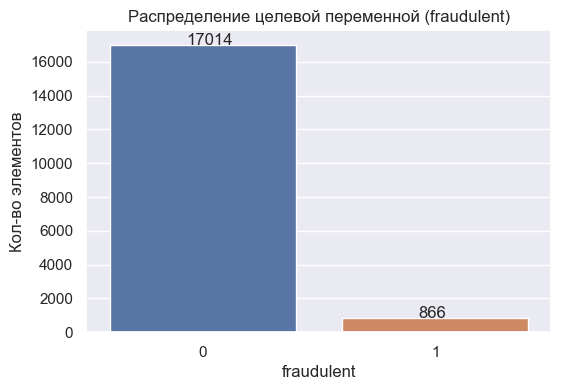

In [47]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('Распределение целевой переменной (fraudulent)')
plt.ylabel('Кол-во элементов')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.33, p.get_height()))

plt.show()

Классы не сбалансированы, так что придётся использовать оверсэмплинг/андерсэмплинг и вычислять другие оценочные метрики помимо точности (ROC AUC и т.д.) при оценке обучаемых моделей в будущем.

Распределения `fraudulent` для бинарных признаков:

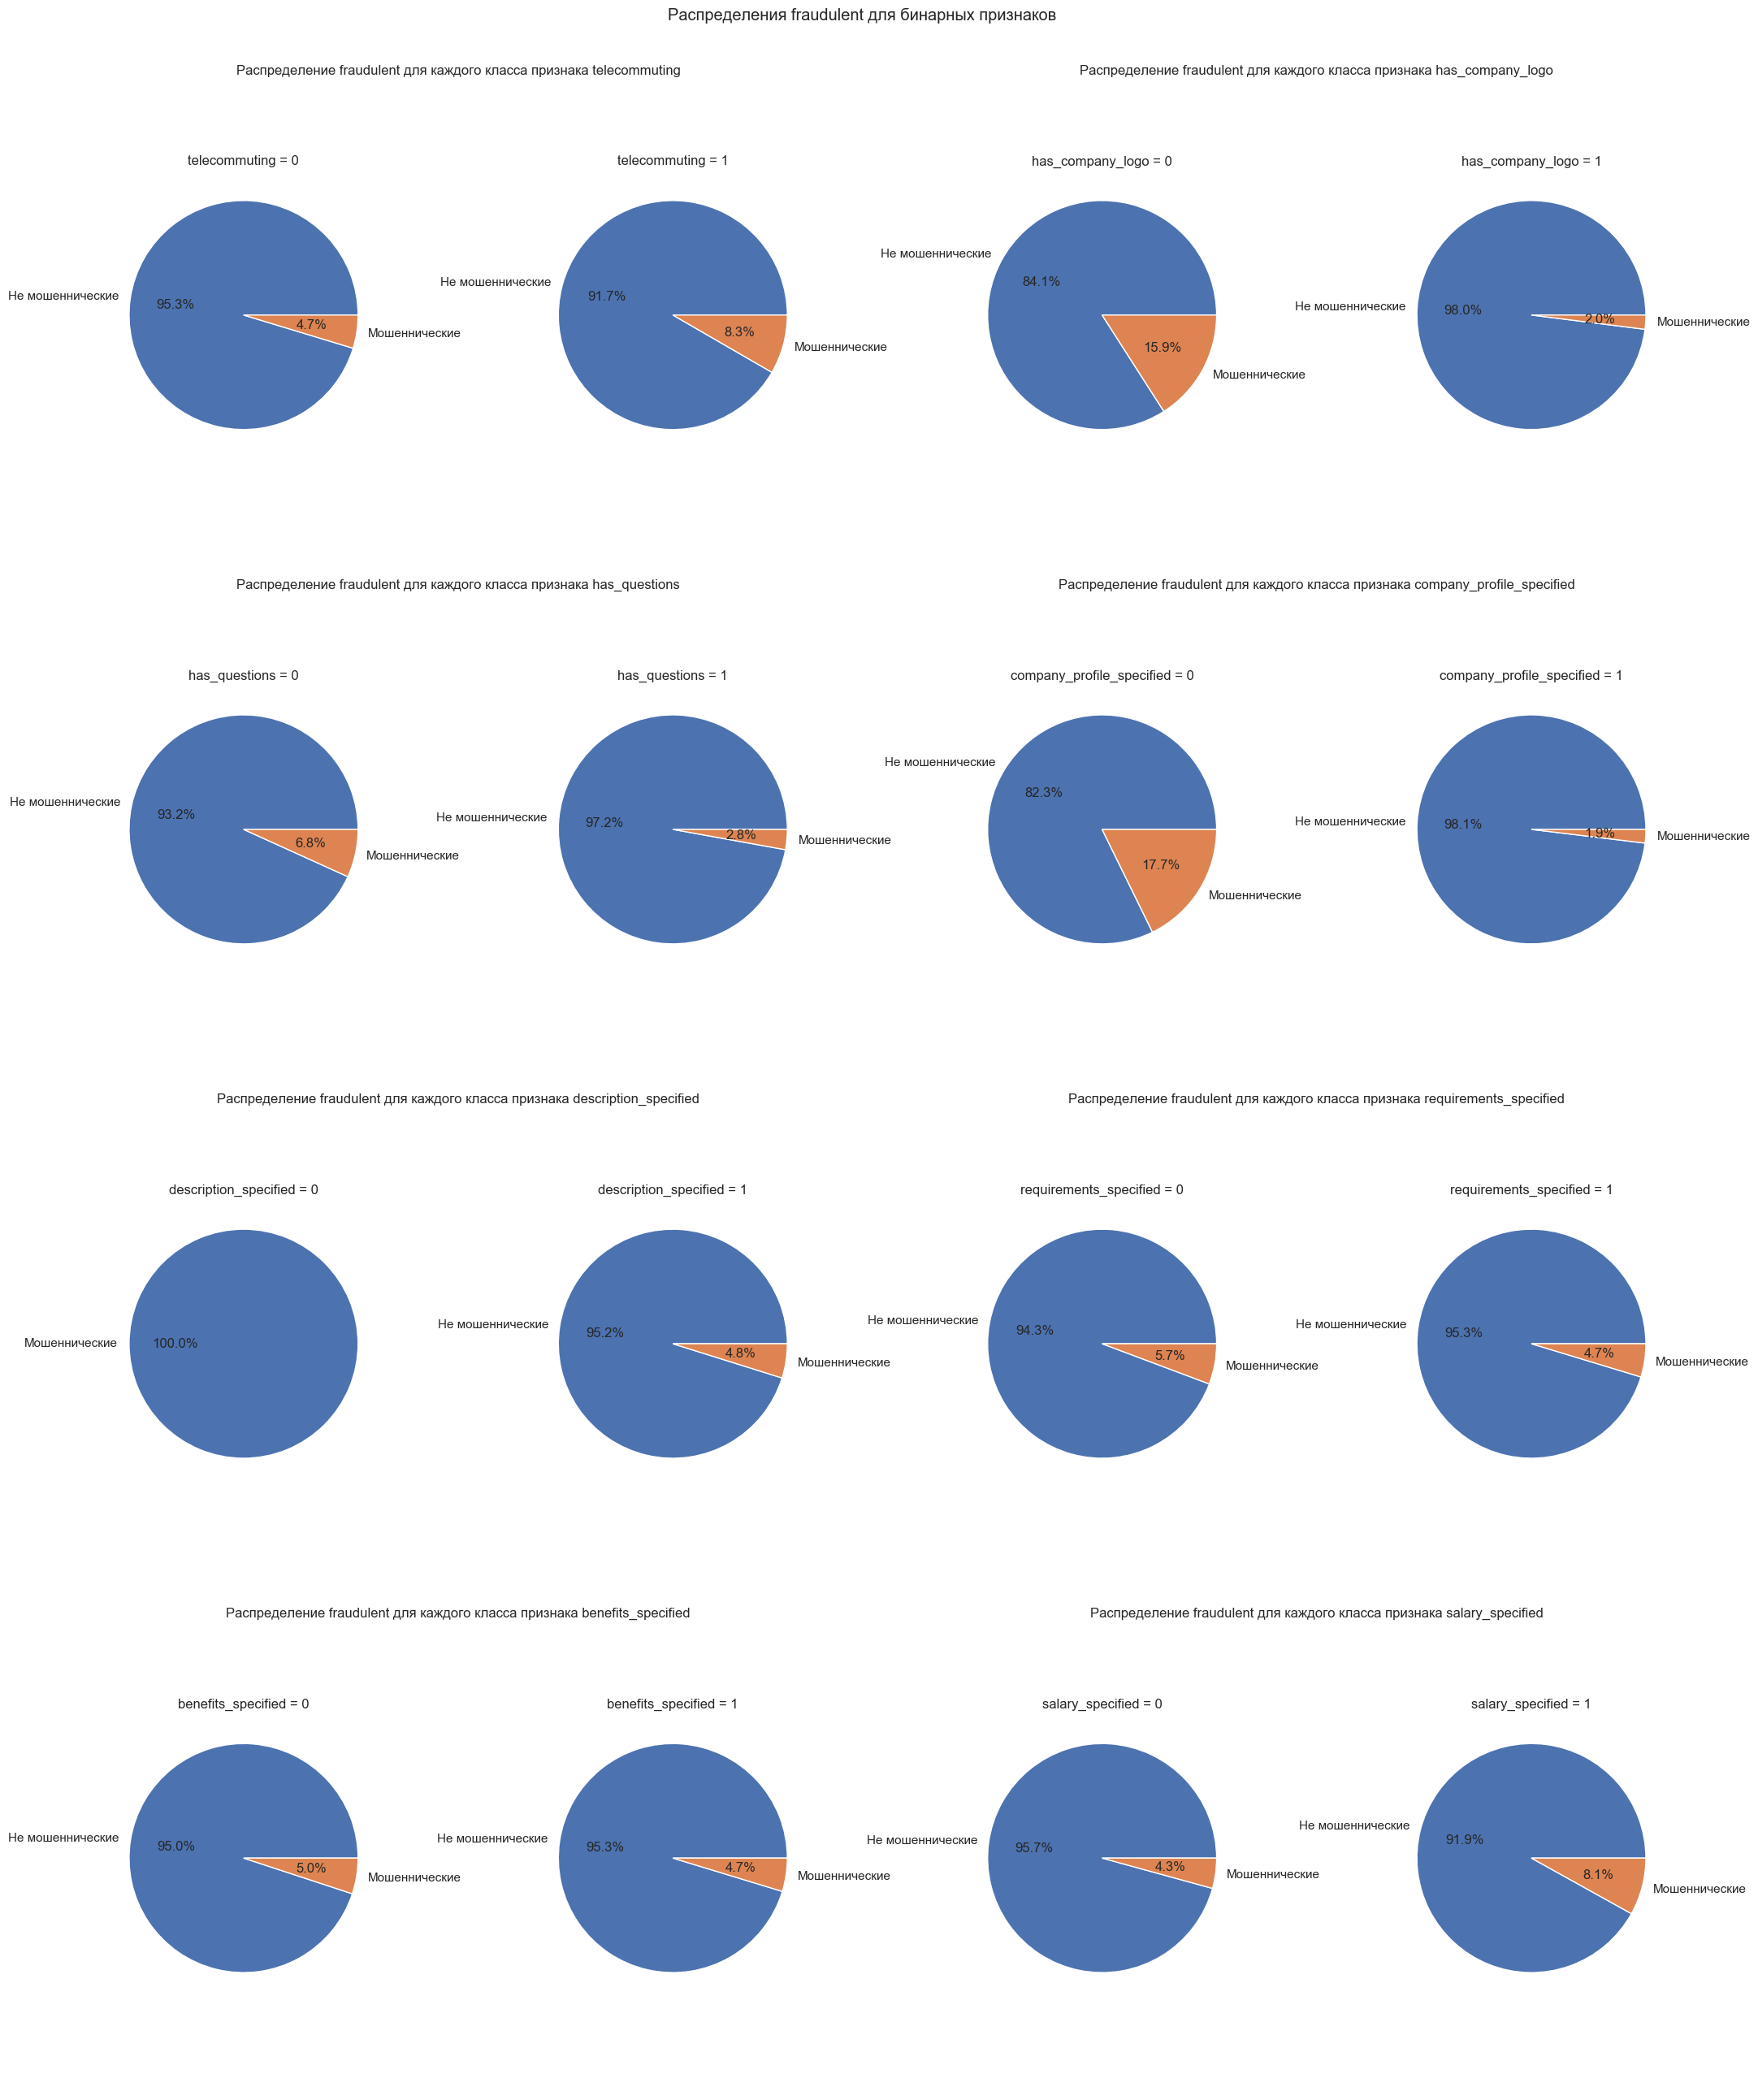

In [48]:
fig = plt.figure(figsize=(25, 30))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.1)

for feature_ind, feature_name in enumerate(bin_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                             wspace=0.5, hspace=0.7)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'Распределение fraudulent для каждого класса признака {feature_name}')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for feature_class in [0, 1]:
        ax = plt.Subplot(fig, inner[feature_class])
        feature_cl_vc = data[data[feature_name] == feature_class].fraudulent.value_counts().sort_index()
        if len(feature_cl_vc) == 2:
            feature_cl_vc.index = ['Не мошеннические', 'Мошеннические']
        else:
            feature_cl_vc.index = ['Мошеннические']
        
        ax.pie(feature_cl_vc.values, labels=feature_cl_vc.index, autopct='%1.1f%%')
        ax.set_title(f'{feature_name} = {feature_class}')
        fig.add_subplot(ax)

fig.suptitle('Распределения fraudulent для бинарных признаков')
fig.subplots_adjust(top=0.95)
fig.show()

Похоже, что у вакансий, выложенных мошенниками, гораздо чаще отсутствуют логотип и описание компании, а также они гораздо реже обещают опросы и собеседования. Ещё они гораздо чаще указывают заработную плату и допускают удалённое трудоустройство.

Распределения `fraudulent` для классов признака `description_specified` могут выглядеть странно. Это потому, что в таблице есть только одна вакансия с неуказанным описанием предлагаемой работы, и она мошенническая:

In [49]:
cont_table = pd.crosstab(data.fraudulent, data.description_specified)
print('Таблица сопряжённости (fraudulent x description_specified):')
display(cont_table)

Таблица сопряжённости (fraudulent x description_specified):


description_specified  0      1
fraudulent                     
0                      0  17014
1                      1    865

Проверим, как некоторые бинарные признаки могут быть связаны между собой:

In [50]:
def show_feature1_x_feature2_info(feature_name1, feature_name2, figsize=(12, 4), is_binxcat=False):
    '''Выводит информацию о комбинации двух бинарных/категориальных признаков.'''
    cont_table = pd.crosstab(data[feature_name1], data[feature_name2]).fillna(0)
    prop_table = pd.pivot_table(data, index=feature_name1, columns=feature_name2, 
                                values='fraudulent', aggfunc=np.mean).fillna(0)
    
    corr, p = stats.cramers_v(cont_table.values)
    
    if is_binxcat:
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    else:
        fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(cont_table, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title(f'Таблица сопряжённости:')
    if is_binxcat:
        axes[0].set_xlabel('')
    
    sns.heatmap(prop_table, annot=True, ax=axes[1])
    axes[1].set_title(f'Доля мошеннических вакансий:')
    
    fig_title = f'{feature_name1} x {feature_name2} (Корреляция: {round(corr, 4)}, p-значение: {round(p, 4)}))'
    if is_binxcat:
        fig.suptitle(fig_title, y=1.05, x=0.45)
    else:
        fig.suptitle(fig_title, y=1.05)
    
    fig.show()

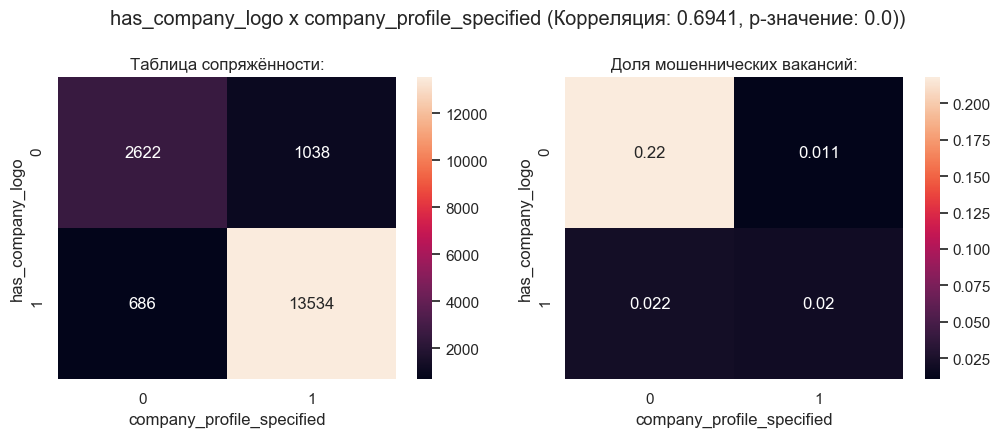

In [51]:
show_feature1_x_feature2_info('has_company_logo', 'company_profile_specified')

Наибольшей вероятностью оказаться мошенническими (при рассмотрении данной комбинации признаков) обладают вакансии без логотипа и описания компании, наименьшей - вакансии, включающие их.

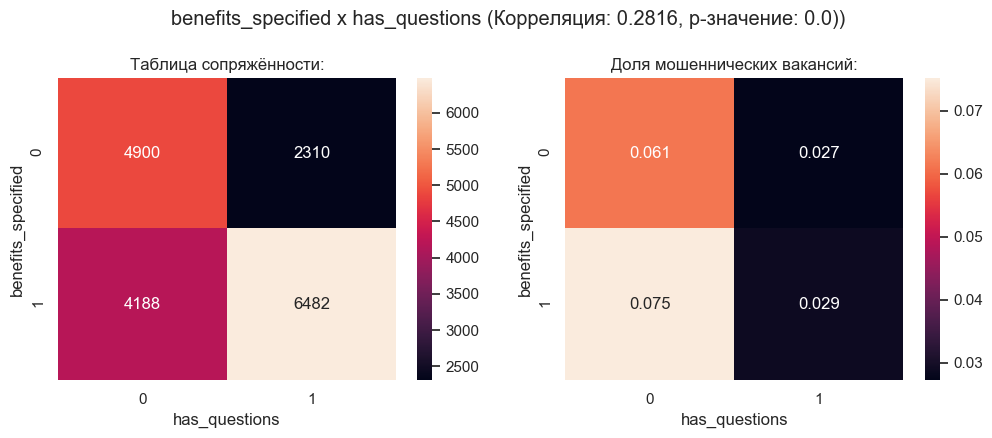

In [52]:
show_feature1_x_feature2_info('benefits_specified', 'has_questions')

Наибольшей вероятностью оказаться мошенническими (при рассмотрении данной комбинации признаков) обладают вакансии, в которых описаны преимущества трудоустройства и обещано отсутствие собеседования.

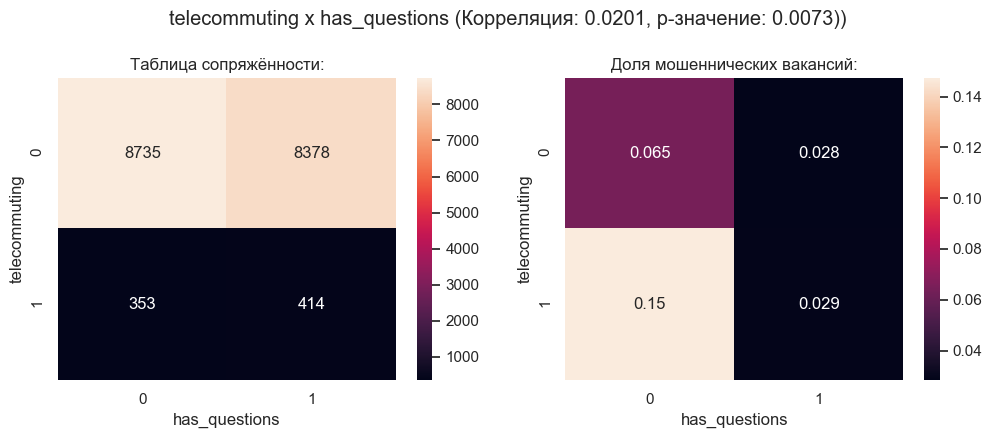

In [53]:
show_feature1_x_feature2_info('telecommuting', 'has_questions')

Наибольшей вероятностью оказаться мошенническими (при рассмотрении данной комбинации признаков) обладают вакансии, предлагающие удалённое трудоустройство и обещающие отсутствие собеседования.

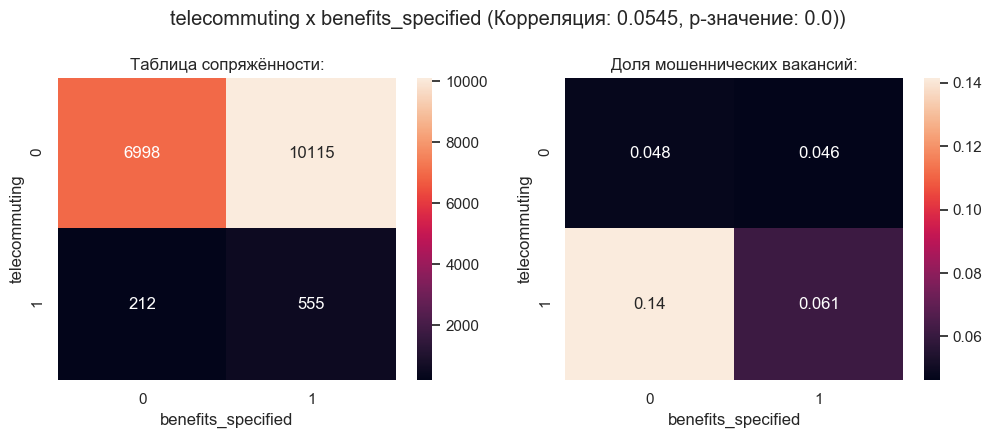

In [54]:
show_feature1_x_feature2_info('telecommuting', 'benefits_specified')

Наибольшей вероятностью оказаться мошенническими (при рассмотрении данной комбинации признаков) обладают вакансии, предлагающие удалённое трудоустройство и не содержащие описания преимуществ работы в данной компании.

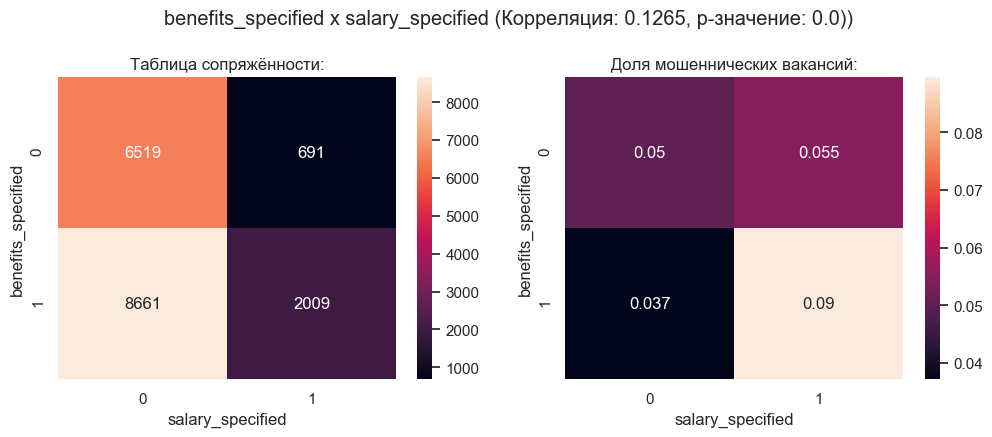

In [55]:
show_feature1_x_feature2_info('benefits_specified', 'salary_specified')

Наибольшей вероятностью оказаться мошенническими (при рассмотрении данной комбинации признаков) обладают вакансии, содержащие описание преимуществ трудоустройства и с указанным диапазоном предлагаемой зарплаты.

Сравним доли мошеннических вакансий для классов признаков `has_questions` и `salary_specified`:

In [56]:
round_confint = lambda confint: list(map(lambda lim: round(lim, 4), confint))

In [57]:
def print_stats_for_proportions(feature_name):
    fraudulent_0 = data[data[feature_name] == 0].fraudulent
    fraudulent_1 = data[data[feature_name] == 1].fraudulent
    
    prop_0 = round(np.mean(fraudulent_0), 4)
    prop_1 = round(np.mean(fraudulent_1), 4)
    prop_0_confint = round_confint(stats.proportion_confint(fraudulent_0))
    prop_1_confint = round_confint(stats.proportion_confint(fraudulent_1))
    
    bigger_prop, smaller_prop = (fraudulent_0, fraudulent_1) if prop_0 > prop_1 else (fraudulent_1, fraudulent_0)
    props_diff = round(np.mean(bigger_prop) - np.mean(smaller_prop), 4)
    props_diff_confint = round_confint(stats.proportions_diff_confint_ind(bigger_prop, smaller_prop))
    z_test_p = stats.proportions_ztest_ind(fraudulent_0, fraudulent_1)[1]
    
    print(f'Признак: {feature_name}\n======')
    print(f'Доля мошеннических вакансий для 0: {prop_0}')
    print(f'Доля мошеннических вакансий для 1: {prop_1}')
    print(f'Доверительный интервал для доли мошеннических вакансий для 0: {prop_0_confint}')
    print(f'Доверительный интервал для доли мошеннических вакансий для 1: {prop_1_confint}')
    print(f'Разница между этими долями: {props_diff}')
    print(f'Доверительный интервал для разницы между этими долями: {props_diff_confint}')
    print(f'Результат Z-теста (двухстороннего): {z_test_p} (p-значение)')

In [58]:
print_stats_for_proportions('has_questions')

Признак: has_questions
Доля мошеннических вакансий для 0: 0.0678
Доля мошеннических вакансий для 1: 0.0284
Доверительный интервал для доли мошеннических вакансий для 0: [0.0628, 0.0731]
Доверительный интервал для доли мошеннических вакансий для 1: [0.0252, 0.0321]
Разница между этими долями: 0.0393
Доверительный интервал для разницы между этими долями: [0.0331, 0.0456]
Результат Z-теста (двухстороннего): 0.0 (p-значение)


In [59]:
round((0.0331 / 0.0284) * 100, 1)

116.5

При выборе из вакансий, в которых обещано отсутствие собеседования, Ваш шанс натолкнуться на мошенника вырастает как минимум на 116.5%, чем при выборе из вакансий, в которых обещаны опрос и проверка специальных навыков.

In [60]:
print_stats_for_proportions('salary_specified')

Признак: salary_specified
Доля мошеннических вакансий для 0: 0.0427
Доля мошеннических вакансий для 1: 0.0807
Доверительный интервал для доли мошеннических вакансий для 0: [0.0396, 0.046]
Доверительный интервал для доли мошеннических вакансий для 1: [0.0711, 0.0916]
Разница между этими долями: 0.0381
Доверительный интервал для разницы между этими долями: [0.0273, 0.0488]
Результат Z-теста (двухстороннего): 0.0 (p-значение)


In [61]:
round((0.0273 / 0.0427) * 100, 1)

63.9

При просмотре вакансий с указанным диапазоном заработной платы шанс встретить мошенническую вырастает как минимум на 63.9%, чем при просмотре вакансий без него.

Рассмотрим категориальные признаки:

In [62]:
for feature_name in cat_features:
    print(f'Количество уникальных значений для {feature_name}: {data[feature_name].unique().shape[0]}')

Количество уникальных значений для department: 1338
Количество уникальных значений для employment_type: 6
Количество уникальных значений для required_experience: 8
Количество уникальных значений для required_education: 13
Количество уникальных значений для industry: 132
Количество уникальных значений для function: 38
Количество уникальных значений для country: 91
Количество уникальных значений для state: 325
Количество уникальных значений для city: 2388


Будет трудно нарисовать любого вида график для каждого категориального признака из-за количества уникальных элементов в большинстве из них. Нарисуем графики для тех, что имеют наименьшее количество классов (модуль `plotly` подходит для этого лучше):

In [63]:
def plot_cat_feature_distribution(feature_name, save_as_image=True):
    '''Рисует plotly-график с распределениями категориального признака для
    мошеннических и не мошеннических вакансий.'''
    feature_0f = data[data.fraudulent == 0][feature_name].value_counts()
    feature_1f = data[data.fraudulent == 1][feature_name].value_counts()
    
    fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], 
                        subplot_titles=['Не мошеннические', 'Мошеннические'])
    fig.add_trace(go.Pie(labels=feature_0f.index, 
                         values=feature_0f.values), 
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=feature_1f.index, 
                         values=feature_1f.values), 
                  row=1, col=2)
    
    fig.update_layout(title_text=f'Распределение {feature_name}')
    fig.show()
    
    if save_as_image:
        fig.write_image(f'images/{feature_name}_distribution_rus.png', width=1200, height=800)

In [64]:
plot_cat_feature_distribution('employment_type')

In [65]:
plot_cat_feature_distribution('required_experience')

In [66]:
plot_cat_feature_distribution('required_education')

In [67]:
func_meanfr_pt = pd.pivot_table(data, index='function', values='fraudulent', 
                                aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
func_meanfr_pt.columns = ['Доля мошеннических вакансий']
print('Топ-15 значений признака function с наибольшими долями мошеннических вакансий:')
display(func_meanfr_pt.head(15))

Топ-15 значений признака function с наибольшими долями мошеннических вакансий:


Доля мошеннических вакансий
function                                         
Administrative                           0.188889
Financial Analyst                        0.151515
Accounting/Auditing                      0.136792
Distribution                             0.125000
Other                                    0.098462
Finance                                  0.087209
Engineering                              0.083828
Business Development                     0.057018
Advertising                              0.055556
Project Management                       0.054645
Customer Service                         0.054516
Unspecified                              0.052208
Data Analyst                             0.048780
Human Resources                          0.043902
Sales                                    0.027929

In [68]:
country_meanfr_pt = pd.pivot_table(data, index='country', values='fraudulent', 
                                   aggfunc=np.mean).sort_values(by='fraudulent', ascending=False)
country_meanfr_pt.columns = ['Доля мошеннических вакансий']
print('Топ-15 значений признака country с наибольшими долями мошеннических вакансий:')
display(country_meanfr_pt.head(15))

Топ-15 значений признака country с наибольшими долями мошеннических вакансий:


Доля мошеннических вакансий
country                                
MY                             0.571429
BH                             0.555556
TW                             0.500000
QA                             0.285714
AU                             0.186916
ID                             0.076923
US                             0.068506
SA                             0.066667
Unpecified                     0.054913
PL                             0.039474
PK                             0.037037
BR                             0.027778
CA                             0.026258
ZA                             0.025000
EG                             0.019231

Проверим, как некоторые категориальные признаки могут быть связаны между собой (и с бинарными):

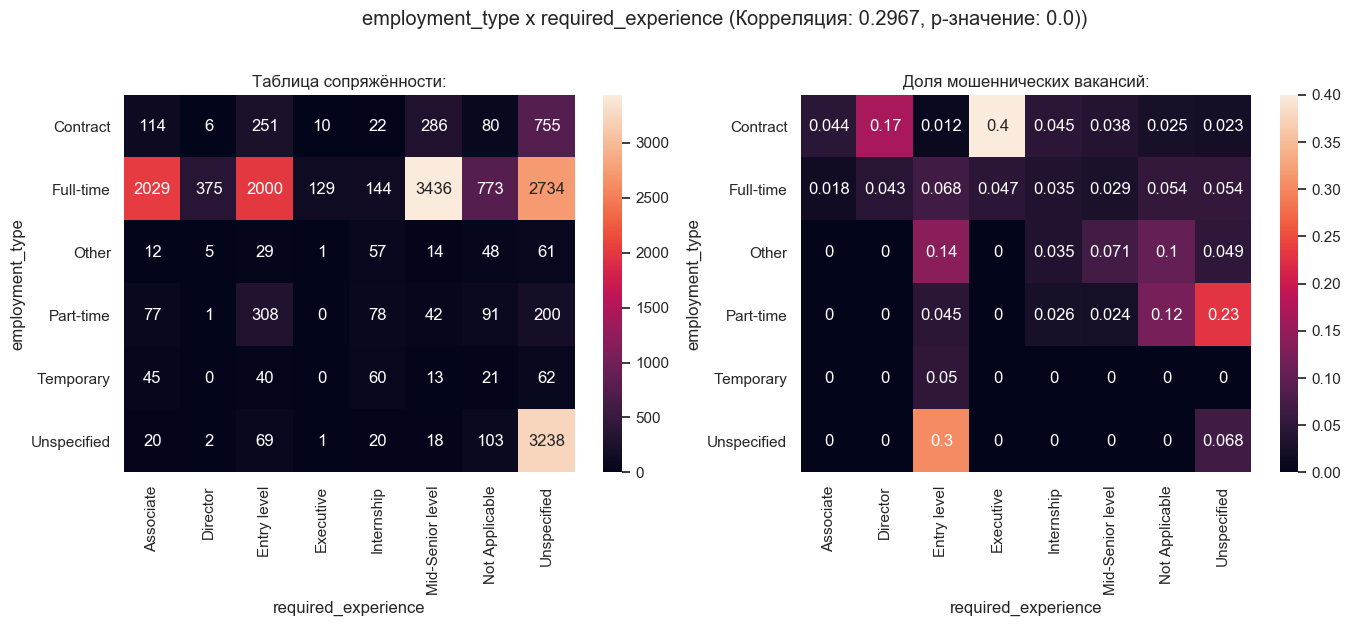

In [69]:
show_feature1_x_feature2_info('employment_type', 'required_experience', (16, 5))

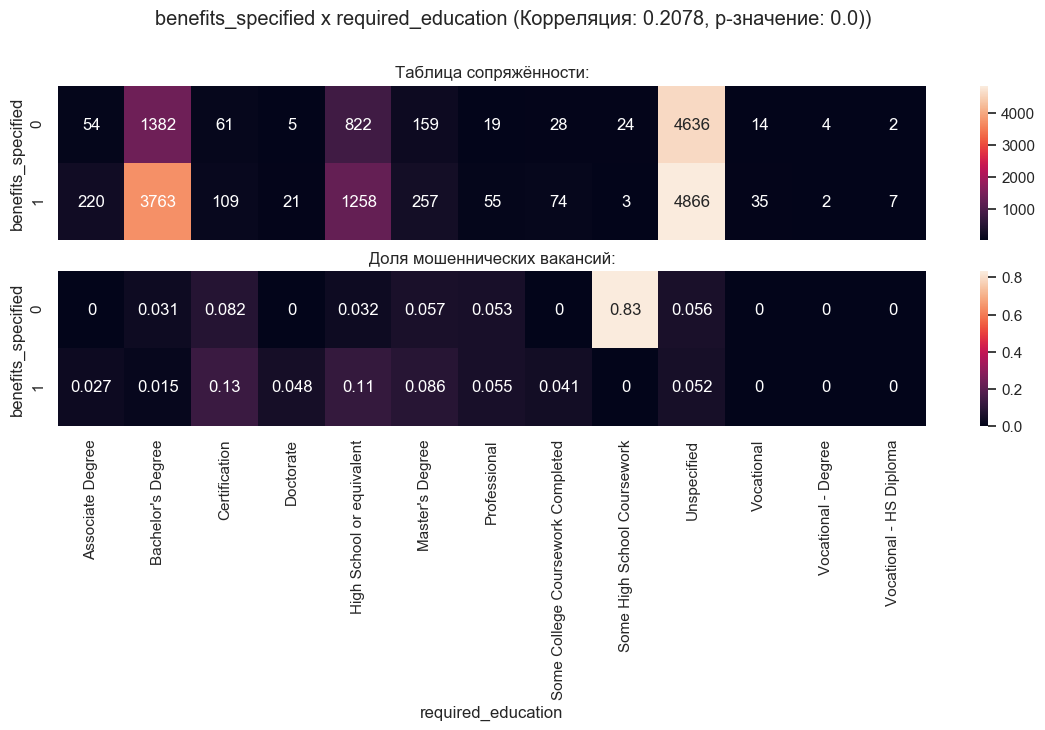

In [70]:
show_feature1_x_feature2_info('benefits_specified', 'required_education', (14, 4.5), True)

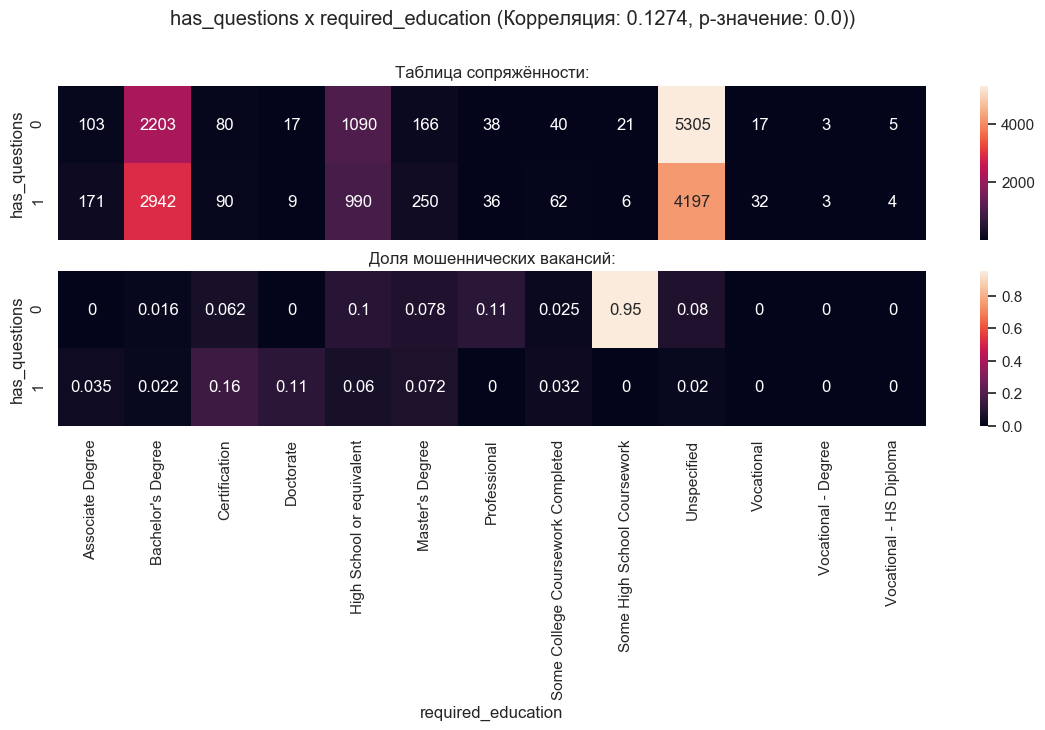

In [71]:
show_feature1_x_feature2_info('has_questions', 'required_education', (14, 4.5), True)

Рассмотрим числовые признаки (информация о заработной плате):

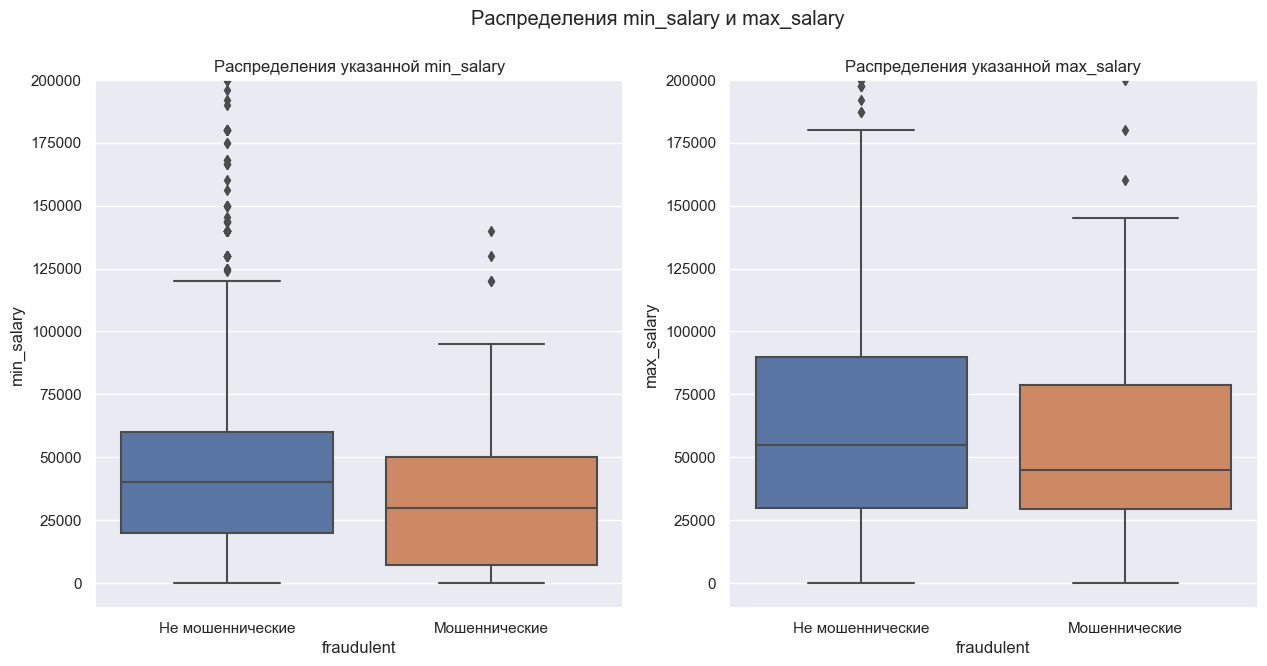

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for ind, feature_name in enumerate(num_features):
    sns.boxplot(y=feature_name, x='fraudulent', data=data[data.salary_specified == 1], ax=axes[ind])
    axes[ind].set_ylim([-1e4, 2e5])
    axes[ind].set_xticklabels(['Не мошеннические', 'Мошеннические'])
    axes[ind].set_title(f'Распределения указанной {feature_name}')

fig.suptitle('Распределения min_salary и max_salary')
fig.show()

Похоже, что мошенники обычно предлагают более низкие зарплаты...

Сравним медианы для каждого признака (так как в выборках слишком много выбросов, сравнивать средние не имеет большого смысла):

In [73]:
specified_salaries = data[data.salary_specified == 1][num_features]
specified_salaries['fraudulent'] = data.fraudulent
specified_salaries.head()

min_salary  max_salary  fraudulent
6        20000       28000           0
10      100000      120000           0
15      120000      150000           0
23      100000      120000           0
31       50000       65000           0

Мы не можем использовать ранговый критерий Манна-Уитни для сравнения распределений потому что - 

In [74]:
np.sum(np.unique(specified_salaries.min_salary, return_counts=True)[1] > 10)

48

In [75]:
np.sum(np.unique(specified_salaries.max_salary, return_counts=True)[1] > 10)

47

\- поэтому мы воспользуемся перестановочным критерием:

In [76]:
def print_stats_for_salary(feature_name):
    np.random.seed(42)
    feature_0f = specified_salaries[specified_salaries.fraudulent == 0][feature_name]
    feature_1f = specified_salaries[specified_salaries.fraudulent == 1][feature_name]
    
    med_0f = np.median(feature_0f)
    med_1f = np.median(feature_1f)
    med_0f_confint = stats.bootstrap_statint(feature_0f.values, stat=np.median)
    med_1f_confint = stats.bootstrap_statint(feature_1f.values, stat=np.median)
    
    bigger_med, smaller_med = (feature_0f, feature_1f) if med_0f > med_1f else (feature_1f, feature_0f)
    med_diff = np.median(bigger_med) - np.median(smaller_med)
    med_diff_confint = stats.bootstrap_statint_diff(bigger_med.values, smaller_med.values, stat=np.median)
    perm_test_p = stats.permutation_test_ind(feature_0f, feature_1f, max_permutations=5000)[1]
    
    print(f'Признак: {feature_name}\n======')
    print(f'Медиана {feature_name} для не мошеннических вакансий: {med_0f}')
    print(f'Медиана {feature_name} для мошеннических вакансий:    {med_1f}')
    print(f'Статистический интервал для медианы {feature_name} для не мошеннических вакансий: {med_0f_confint}')
    print(f'Статистический интервал для медианы {feature_name} для мошеннических вакансий:    {med_1f_confint}')
    print(f'Разница между этими медианами: {med_diff}')
    print(f'Статистический интервал для разницы между этими медианами: {med_diff_confint}')
    print(f'Результат перестановочного теста (двухстороннего): {perm_test_p} (p-значение)')

In [77]:
print_stats_for_salary('min_salary')

Признак: min_salary
Медиана min_salary для не мошеннических вакансий: 40000.0
Медиана min_salary для мошеннических вакансий:    30000.0
Статистический интервал для медианы min_salary для не мошеннических вакансий: [39000. 40000.]
Статистический интервал для медианы min_salary для мошеннических вакансий:    [27000. 30000.]
Разница между этими медианами: 10000.0
Статистический интервал для разницы между этими медианами: [ 9000. 13000.]
Результат перестановочного теста (двухстороннего): 0.8066 (p-значение)


In [78]:
print_stats_for_salary('max_salary')

Признак: max_salary
Медиана max_salary для не мошеннических вакансий: 55000.0
Медиана max_salary для мошеннических вакансий:    45000.0
Статистический интервал для медианы max_salary для не мошеннических вакансий: [50000. 58000.]
Статистический интервал для медианы max_salary для мошеннических вакансий:    [40000. 50000.]
Разница между этими медианами: 10000.0
Статистический интервал для разницы между этими медианами: [    0. 15000.]
Результат перестановочного теста (двухстороннего): 0.8924 (p-значение)


Разница между медианами минимальных зарплат гораздо более значима, чем между медианами максимальных зарплат, однако результаты перестановочных тестов говорят о том, что распределения ни в одном из случаев нельзя назвать значимо отличающимися друг от друга.

Сравним среднюю длину текстов и её распределения для мошеннических и не мошеннических вакансий для каждого текстового признака:

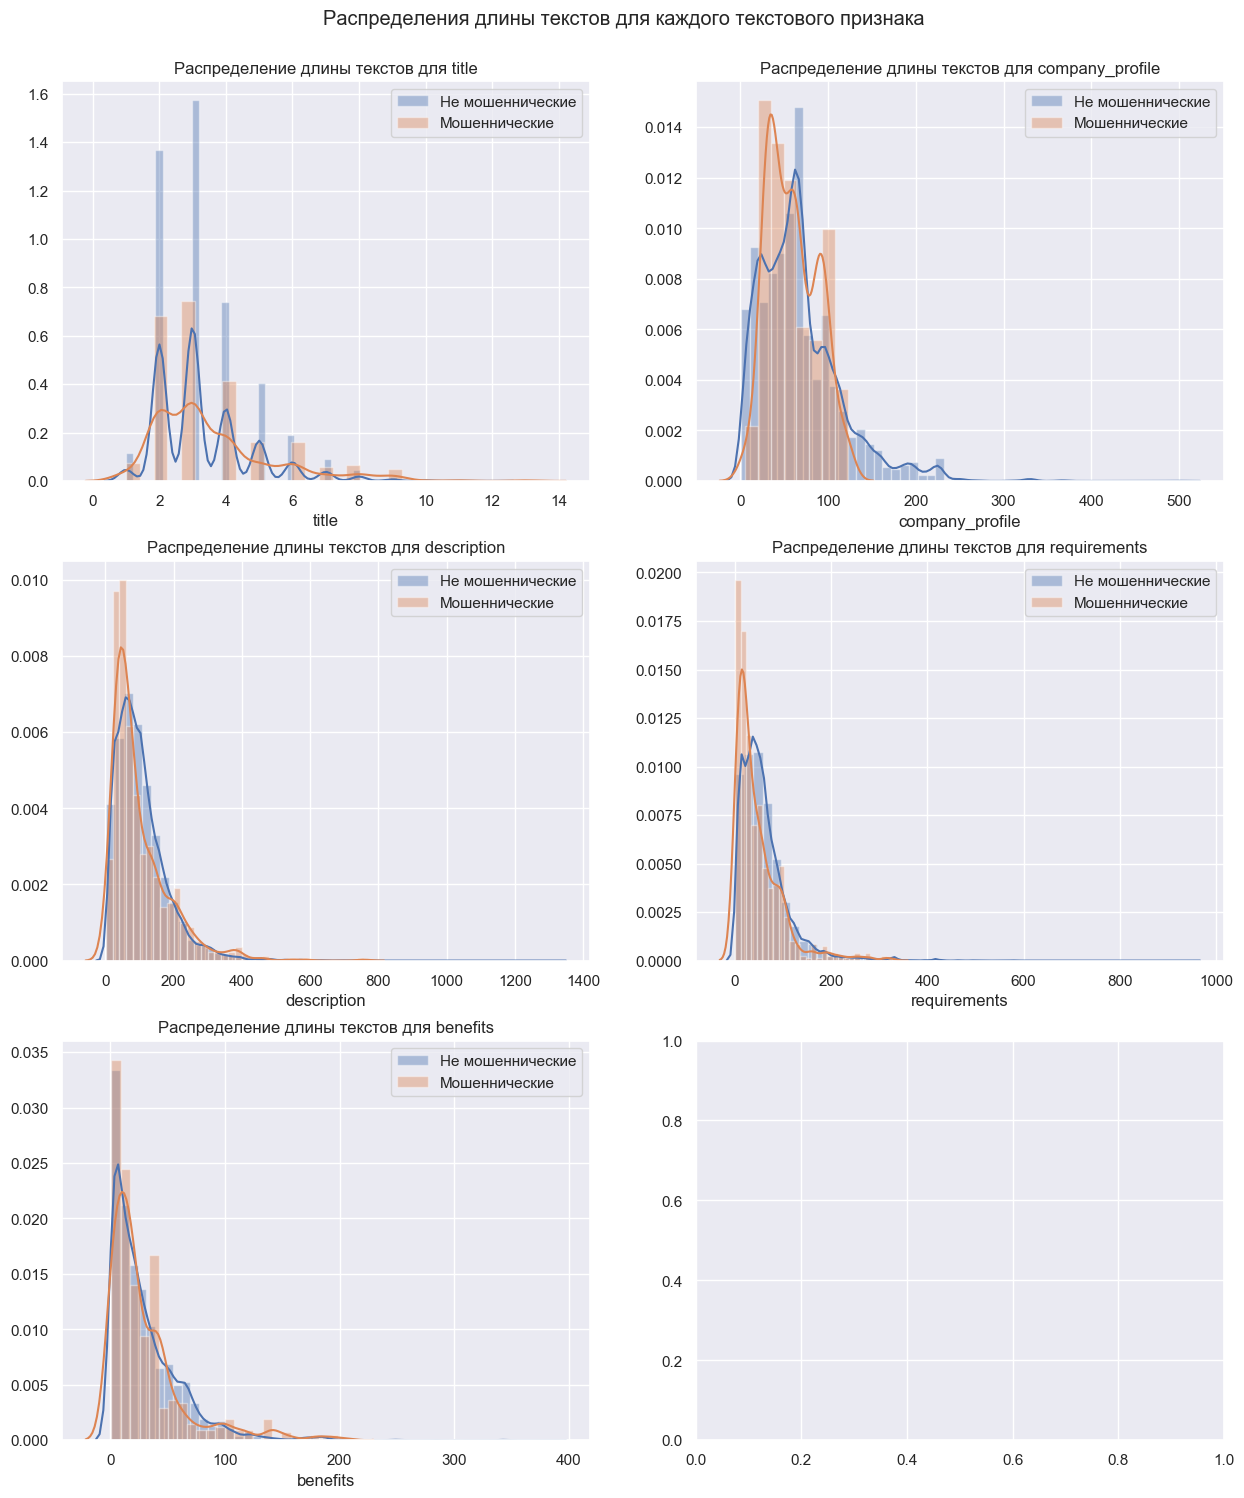

In [79]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

text_features_gen = iter(text_features)

for row in range(3):
    for col in range(2):
        try:
            feature_name = next(text_features_gen)
        except StopIteration:
            break
        
        if feature_name == 'title':
            feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
        else:
            feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
            feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)

        fv_0f_len = feature_values_0f.str.split(' ').apply(len)
        fv_1f_len = feature_values_1f.str.split(' ').apply(len)
        
        sns.distplot(fv_0f_len, label='Не мошеннические', ax=axes[row, col])
        sns.distplot(fv_1f_len, label='Мошеннические', ax=axes[row, col])
        axes[row, col].set_title(f'Распределение длины текстов для {feature_name}')
        axes[row, col].legend()
        
fig.suptitle('Распределения длины текстов для каждого текстового признака', y=0.92)
fig.show()

In [80]:
def print_stats_for_texts(feature_name):
    if feature_name == 'title':
        feature_values_0f = data[(data.fraudulent == 0)][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1)][feature_name].astype(str)
    else:
        feature_values_0f = data[(data.fraudulent == 0) & data[f'{feature_name}_specified']][feature_name].astype(str)
        feature_values_1f = data[(data.fraudulent == 1) & data[f'{feature_name}_specified']][feature_name].astype(str)
    
    lens_0f = feature_values_0f.str.split(' ').apply(len)
    lens_1f = feature_values_1f.str.split(' ').apply(len)
    
    mean_lens_0f = round(np.mean(lens_0f), 4)
    mean_lens_1f = round(np.mean(lens_1f), 4)
    mean_lens_0f_confint = round_confint(stats.tconfint(lens_0f.values))
    mean_lens_1f_confint = round_confint(stats.tconfint(lens_1f.values))
    
    bigger_mean, smaller_mean = (lens_0f, lens_1f) if mean_lens_0f > mean_lens_1f else (lens_1f, lens_0f)
    mean_diff = round(np.mean(bigger_mean) - np.mean(smaller_mean), 4)
    
    mean_diff_confint = round_confint(stats.tconfint_diff(bigger_mean.values, smaller_mean.values))
    perm_test_p = stats.permutation_test_ind(lens_0f, lens_1f, max_permutations=5000)[1]
    
    print(f'Признак: {feature_name}\n======')
    print(f'Средняя длина текстов в {feature_name} для не мошеннических вакансий: {mean_lens_0f}')
    print(f'Средняя длина текстов в {feature_name} для мошеннических вакансий:    {mean_lens_1f}')
    print(f'Доверительный интервал для средней длины текстов в {feature_name} для не мошеннических вакансий: {mean_lens_0f_confint}')
    print(f'Доверительный интервал для средней длины текстов в {feature_name} для мошеннических вакансий:    {mean_lens_1f_confint}')
    print(f'Разница между этими средними: {mean_diff}')
    print(f'Доверительный интервал для разницы между этими средними: {mean_diff_confint}')
    print(f'Результат перестановочного теста (двухстороннего): {perm_test_p} (p-значение)')

In [81]:
for feature_name in text_features:
    print_stats_for_texts(feature_name)
    print()

Признак: title
Средняя длина текстов в title для не мошеннических вакансий: 3.2794
Средняя длина текстов в title для мошеннических вакансий:    3.5612
Доверительный интервал для средней длины текстов в title для не мошеннических вакансий: [3.258, 3.3007]
Доверительный интервал для средней длины текстов в title для мошеннических вакансий:    [3.4392, 3.6832]
Разница между этими средними: 0.2818
Доверительный интервал для разницы между этими средними: [0.158, 0.4057]
Результат перестановочного теста (двухстороннего): 0.0002 (p-значение)

Признак: company_profile
Средняя длина текстов в company_profile для не мошеннических вакансий: 66.9309
Средняя длина текстов в company_profile для мошеннических вакансий:    59.2294
Доверительный интервал для средней длины текстов в company_profile для не мошеннических вакансий: [66.1698, 67.692]
Доверительный интервал для средней длины текстов в company_profile для мошеннических вакансий:    [55.9672, 62.4916]
Разница между этими средними: 7.7015
Довер

Создадим два новых числовых признака для длин текстов в `company_profile` и `requirements` (потому что их распределения скорее всего неодинаковы согласно перестановочному тесту, так же, как и распределения длин текстов в `title`, но максимальное отличие средних равное примерно 0.4 слова не является высоким размером эффекта с точки зрения логики):

In [82]:
data['company_profile_count_of_words'] = data['company_profile'].astype(str).str.split(' ').apply(len)
data['requirements_count_of_words'] = data['requirements'].astype(str).str.split(' ').apply(len)
data.head()[['company_profile_count_of_words', 'requirements_count_of_words']]

company_profile_count_of_words  requirements_count_of_words
0                              86                           73
1                              96                          117
2                              75                          103
3                              55                          121
4                             146                           61

In [83]:
num_features += ['company_profile_count_of_words', 'requirements_count_of_words']

Теперь данные готовы к тренировке моделей.

## Тренировка моделей

Сначала увеличим количество записей о мошеннических вакансиях в датасете используя оверсэмплинг:

In [84]:
data_1f = data[data.fraudulent == 1]

In [85]:
original_data = data.copy()
data = pd.concat([data] + [data_1f] * 7, axis=0)

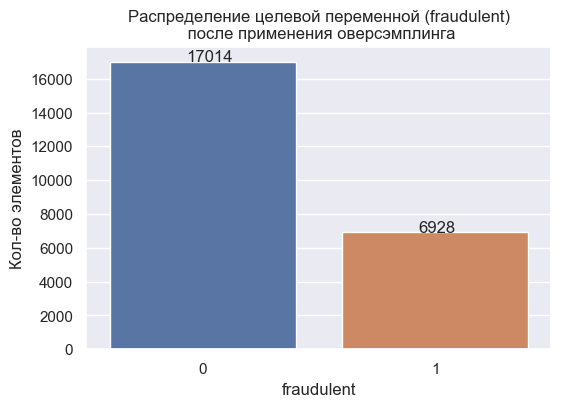

In [86]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data.fraudulent)
plt.title('Распределение целевой переменной (fraudulent)\n после применения оверсэмплинга')
plt.ylabel('Кол-во элементов')
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.33, p.get_height()))

plt.show()

Механизм кросс-валидационного разбиения:

In [87]:
skf = StratifiedKFold(n_splits=4, random_state=42)

Делим данные на признаки и целевую переменную:

In [88]:
X, y = data.drop('fraudulent', axis=1), data.fraudulent

Числовые признаки должны быть отмасштабированы, категориальные признаки должны быть трансформированы в наборы бинарных, а текстовые - векторизированы (здесь используется TF-IDF метод):

In [89]:
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2)))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        *[(feature_name, text_transformer, feature_name) 
          for feature_name in text_features]
    ]
)

Начнём с модели логистической регрессии (параметры по умолчанию):

In [90]:
log_reg_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', LogisticRegression())])

In [91]:
%%time
cv_scores = cross_validate(log_reg_pipe, X, y, return_train_score=True, cv=skf, 
                           scoring=['accuracy', 'roc_auc'], n_jobs=-1)

print(f'Точности на тренировочных наборах: {cv_scores["train_accuracy"]}, среднее: {cv_scores["train_accuracy"].mean()}')
print(f'Точности на тестовых наборах:      {cv_scores["test_accuracy"]}, среднее: {cv_scores["test_accuracy"].mean()}')
print(f'ROC AUC на тренировочных наборах: {cv_scores["train_roc_auc"]}, среднее: {cv_scores["train_roc_auc"].mean()}')
print(f'ROC AUC на тестовых наборах:      {cv_scores["test_roc_auc"]}, среднее: {cv_scores["test_roc_auc"].mean()}')

Точности на тренировочных наборах: [0.99955447 0.99949877 0.99944311 0.99955449], среднее: 0.999512711661765
Точности на тестовых наборах:      [0.99031073 0.98897427 0.99565581 0.99298246], среднее: 0.9919808151629771
ROC AUC на тренировочных наборах: [0.99996805 0.99999149 0.99996806 0.99996996], среднее: 0.9999743907255456
ROC AUC на тестовых наборах:      [0.99920032 0.99854423 0.99986424 0.99934512], среднее: 0.9992384775819498
CPU times: user 524 ms, sys: 415 ms, total: 939 ms
Wall time: 3min 4s


Думаю, что здесь можно остановиться. Возможно, датасет был собран неправильно или в нём слишком мало записей... Или, может быть, я сделал что-то неправильно, но данные очень просто классифицировать. Или, может, всё в порядке? Посмотрим на веса модели:

In [92]:
%%time
feature_names = num_features.copy()

num_features_scaled = StandardScaler().fit_transform(data[num_features])
X = num_features_scaled

feature_names += bin_features
X = np.hstack([X, data[bin_features]])


for feature_name in cat_features:
    encoder = OneHotEncoder()
    encoded_feature = encoder.fit_transform(data[feature_name].values.reshape(-1, 1))
    
    X = sparse_hstack([X, encoded_feature])
    f_names = list(map(lambda cat: f'{feature_name}:{cat}', encoder.categories_[0]))
    feature_names += f_names

for feature_name in text_features:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    vectorized_feature = vectorizer.fit_transform(data[feature_name])
    
    X = sparse_hstack([X, vectorized_feature])
    sorted_phrases = [pair[0] for pair in list(sorted(vectorizer.vocabulary_.items(), 
                                                      key=lambda pair: pair[1]))]
    f_names = list(map(lambda phrase: f'{feature_name}:{phrase}', sorted_phrases))
    feature_names += f_names

CPU times: user 20.2 s, sys: 1.13 s, total: 21.3 s
Wall time: 22.5 s


In [93]:
X.shape[1], len(feature_names)

(1273071, 1273071)

In [94]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1).fit(X, y)

Веса и соответствующие им имена признаков:

In [95]:
eli5.explain_weights(log_reg, feature_names=feature_names, top=(30, 30))

Explanation(estimator="LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=100,\n                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,\n                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)", description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='department:Information Technology ', weight=2.556101458238224, std=None, value=None), FeatureWeight(feature='industry:Oil & Energy', weight=2.5473435087483502, std=None, value=None), FeatureWeight(feature='country:MY', weight=2.369502163799219, std=None, value=None), FeatureWeight(feature='benefits:salaryk', weight=2.277619821078909, std=None, value=None), FeatureWeight(feature='title:administr', weight=2.270859528351265, std=None, value=None), FeatureWeight(feature='title:custom assist', weight=2.247909618957874, std=None, value=None), FeatureWeight(feature='city:AUSTIN', weight=2.2450333405549108, std=None, value=None), FeatureWeight(feature='city:San Mateo', weight=2.2278144404522306, std=None, value=None), FeatureWeight(feature='title:posit', weight=2.1648660035597818, std=None, value=None), FeatureWeight(feature='industry:Accounting', weight=2.1071055397264824, std=None, value=None), FeatureWeight(feature='company_profile:accion', weight=2.0193531947824743, std=None, value=None), FeatureWeight(feature='department:Oil & Energy', weight=1.879187302778643, std=None, value=None), FeatureWeight(feature='company_profile:bonu', weight=1.7359802168178582, std=None, value=None), FeatureWeight(feature='country:Unpecified', weight=1.731352825419765, std=None, value=None), FeatureWeight(feature='title:home', weight=1.723027894787846, std=None, value=None), FeatureWeight(feature='industry:Hospitality', weight=1.6362518740060137, std=None, value=None), FeatureWeight(feature='city:london', weight=1.5674002872969683, std=None, value=None), FeatureWeight(feature='city:DALLAS', weight=1.553014657225083, std=None, value=None), FeatureWeight(feature='title:csr', weight=1.537688922245101, std=None, value=None), FeatureWeight(feature='title:center', weight=1.4933558605062556, std=None, value=None), FeatureWeight(feature='city:Groveport', weight=1.4751250157495575, std=None, value=None), FeatureWeight(feature='country:AU', weight=1.472415801944184, std=None, value=None), FeatureWeight(feature='city:Bakersfield', weight=1.4718246003082474, std=None, value=None), FeatureWeight(feature='description:earn', weight=1.467949664564216, std=None, value=None), FeatureWeight(feature='company_profile:aptitud staf', weight=1.441346749256643, std=None, value=None), FeatureWeight(feature='industry:Hospital & Health Care', weight=1.4251943573654036, std=None, value=None), FeatureWeight(feature='company_profile:aptitud', weight=1.4247850371947992, std=None, value=None), FeatureWeight(feature='city:Bellevue', weight=1.422950351268576, std=None, value=None), FeatureWeight(feature='title:work', weight=1.419959587137489, std=None, value=None), FeatureWeight(feature='city:chicago', weight=1.4176436670310324, std=None, value=None)], neg=[FeatureWeight(feature='industry:Restaurants', weight=-2.0223921021348596, std=None, value=None), FeatureWeight(feature='<BIAS>', weight=-1.8975657622141986, std=None, value=None), FeatureWeight(feature='industry:Internet', weight=-1.8631891772174585, std=None, 

Выглядит очень даже хорошо!

Значение признака `country` с наибольшим положительным весом - `MY`, оно было топ-1 в списке топ стран с наибольшей долей мошеннических вакансий. Значение признака `country` с наибольшим отрицательным весом - `GR`:

In [96]:
original_data[original_data.country == 'MY'].fraudulent.value_counts().sort_index()

0     9
1    12
Name: fraudulent, dtype: int64

In [97]:
original_data[original_data.country == 'GR'].fraudulent.value_counts().sort_index()

0    940
Name: fraudulent, dtype: int64

С помощью информации о весах можно узнать, какие признаки ассоциируются с большими и с меньшими долями мошеннических вакансий:

In [98]:
original_data[original_data.industry == 'Accounting'].fraudulent.value_counts().sort_index()

0    102
1     57
Name: fraudulent, dtype: int64

In [99]:
original_data[original_data.industry == 'Internet'].fraudulent.value_counts().sort_index()

0    1062
Name: fraudulent, dtype: int64

Можно также отметить, что мошенники часто пишут названия городов (как, например, London) с маленькой буквы:

In [100]:
original_data[original_data.city == 'london'].fraudulent.value_counts().sort_index()

0    11
1     3
Name: fraudulent, dtype: int64

In [101]:
original_data[original_data.city == 'London'].fraudulent.value_counts().sort_index()

0    1056
1       4
Name: fraudulent, dtype: int64

In [102]:
original_data[original_data.city == 'chicago'].fraudulent.value_counts().sort_index()

0    8
1    4
Name: fraudulent, dtype: int64

In [103]:
original_data[original_data.city == 'Chicago'].fraudulent.value_counts().sort_index()

0    253
1      4
Name: fraudulent, dtype: int64